# Advanced Manufacturing Plant Demand Forecasting

## Project Overview
**Objective**: AI-driven short-term demand forecasting for manufacturing plants to optimize:
- Raw material procurement
- Inventory management
- Production planning
- Working capital optimization

**Key Features**:
- Multi-plant, multi-product forecasting
- Raw material requirement planning
- Supply chain disruption modeling
- Economic indicator integration
- Capacity utilization optimization

In [17]:
# Advanced Manufacturing Demand Forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Libraries
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Utilities
import warnings
import joblib
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [18]:
# Load Manufacturing Data
print("Loading manufacturing demand data...")

# Main demand data
demand_df = pd.read_csv('../data/manufacturing_demand_data.csv')
demand_df['date'] = pd.to_datetime(demand_df['date'])

# Supporting data
raw_materials = pd.read_csv('../data/raw_materials_master.csv')
plant_capacity = pd.read_csv('../data/plant_capacity.csv')

print(f"📊 Demand Data Shape: {demand_df.shape}")
print(f"📅 Date Range: {demand_df['date'].min()} to {demand_df['date'].max()}")
print(f"🏭 Plants: {demand_df['plant_id'].nunique()}")
print(f"📦 Products: {demand_df['product_line'].nunique()}")
print(f"🔧 Raw Materials: {raw_materials.shape[0]}")

demand_df.head()

Loading manufacturing demand data...
📊 Demand Data Shape: (45264, 19)
📅 Date Range: 2023-01-01 00:00:00 to 2025-07-31 00:00:00
🏭 Plants: 4
📦 Products: 12
🔧 Raw Materials: 16


,date,plant_id,product_line,product_category,demand_units,raw_material_1,raw_material_2,raw_material_3,raw_material_4,economic_index,capacity_utilization,supply_chain_disruption,working_days_month,is_holiday,fuel_cost_index,labor_availability,inventory_level,lead_time_days,order_backlog
0,2023-01-01,Plant_A_Mumbai,ECB001,Electronics,923,Silicon_Wafers,Copper_Wire,Plastic_Components,PCB_Boards,99.72,0.850,0,0,1,49.30,0.812,2635,7,99
1,2023-01-02,Plant_A_Mumbai,ECB001,Electronics,1280,Silicon_Wafers,Copper_Wire,Plastic_Components,PCB_Boards,100.96,0.880,0,2,0,47.91,0.988,2933,14,276
2,2023-01-03,Plant_A_Mumbai,ECB001,Electronics,790,Silicon_Wafers,Copper_Wire,Plastic_Components,PCB_Boards,103.42,0.831,1,3,0,49.80,0.995,2306,5,363
3,2023-01-04,Plant_A_Mumbai,ECB001,Electronics,1390,Silicon_Wafers,Copper_Wire,Plastic_Components,PCB_Boards,105.64,0.852,0,4,0,53.27,0.834,2714,4,387
4,2023-01-05,Plant_A_Mumbai,ECB001,Electronics,1457,Silicon_Wafers,Copper_Wire,Plastic_Components,PCB_Boards,102.02,0.704,0,5,0,50.54,0.937,1275,5,205


In [19]:
# Data Quality Assessment
print("=== DATA QUALITY REPORT ===")
print(f"Missing values: {demand_df.isnull().sum().sum()}")
print(f"Duplicate records: {demand_df.duplicated().sum()}")
print(f"Negative demand values: {(demand_df['demand_units'] < 0).sum()}")

# Statistical summary
print("\n=== DEMAND STATISTICS ===")
demand_stats = demand_df.groupby(['plant_id', 'product_category'])['demand_units'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(2)
print(demand_stats)

# Supply chain disruptions
disruption_rate = demand_df['supply_chain_disruption'].mean() * 100
print(f"\n📊 Supply Chain Disruption Rate: {disruption_rate:.2f}%")

=== DATA QUALITY REPORT ===
Missing values: 0
Duplicate records: 0
Negative demand values: 0

=== DEMAND STATISTICS ===
                                    count     mean     std  min   max
plant_id          product_category                                   
Plant_A_Mumbai    Automotive         2829   899.73  281.41  175  1846
                  Chemicals          2829   679.01  213.56  131  1376
                  Electronics        2829  1128.16  355.66  343  2206
                  Textiles           2829  1350.67  420.91  390  2844
Plant_B_Chennai   Automotive         2829   750.37  232.72  223  1571
                  Chemicals          2829   561.98  172.54  136  1092
                  Electronics        2829   938.63  291.29  288  1880
                  Textiles           2829  1130.11  350.80  309  2300
Plant_C_Pune      Automotive         2829   676.74  212.42  179  1338
                  Chemicals          2829   506.93  158.65  138  1021
                  Electronics        282

In [20]:
# Advanced Exploratory Data Analysis
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Demand Trends by Plant', 'Seasonal Patterns', 'Capacity Utilization', 'Economic Impact'),
    specs=[[{"secondary_y": True}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": True}]]
)

# 1. Demand trends by plant
monthly_demand = demand_df.groupby(['date', 'plant_id'])['demand_units'].sum().reset_index()
monthly_demand['year_month'] = monthly_demand['date'].dt.to_period('M')
monthly_agg = monthly_demand.groupby(['year_month', 'plant_id'])['demand_units'].sum().reset_index()

for plant in demand_df['plant_id'].unique():
    plant_data = monthly_agg[monthly_agg['plant_id'] == plant]
    fig.add_trace(
        go.Scatter(x=plant_data['year_month'].astype(str), y=plant_data['demand_units'],
                  mode='lines+markers', name=plant, line=dict(width=2)),
        row=1, col=1
    )

# 2. Seasonal patterns
seasonal_data = demand_df.groupby(demand_df['date'].dt.dayofyear)['demand_units'].mean()
fig.add_trace(
    go.Scatter(x=seasonal_data.index, y=seasonal_data.values,
              mode='lines', name='Seasonal Pattern', line=dict(color='orange', width=3)),
    row=1, col=2
)

# 3. Capacity utilization distribution
fig.add_trace(
    go.Histogram(x=demand_df['capacity_utilization'], nbinsx=30, name='Capacity Utilization',
                marker_color='lightblue'),
    row=2, col=1
)

# 4. Economic index vs demand correlation
fig.add_trace(
    go.Scatter(x=demand_df['economic_index'], y=demand_df['demand_units'],
              mode='markers', name='Economic Impact', marker=dict(size=4, color='red', opacity=0.5)),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Manufacturing Demand Analysis Dashboard", showlegend=True)
fig.show()

print("📈 Interactive analysis dashboard created")

📈 Interactive analysis dashboard created


In [21]:
# Advanced Feature Engineering for Manufacturing
def create_manufacturing_features(df):
    """Create advanced features for manufacturing demand forecasting"""
    
    df = df.copy()
    df = df.sort_values(['plant_id', 'product_line', 'date'])
    
    # Time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Lag features (by plant and product)
    for lag in [1, 3, 7, 14, 21, 28]:
        df[f'demand_lag_{lag}'] = df.groupby(['plant_id', 'product_line'])['demand_units'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14, 30]:
        df[f'demand_rolling_mean_{window}'] = df.groupby(['plant_id', 'product_line'])['demand_units'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'demand_rolling_std_{window}'] = df.groupby(['plant_id', 'product_line'])['demand_units'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    # Manufacturing-specific features
    df['capacity_efficiency'] = df['demand_units'] / (df['capacity_utilization'] * 5000)  # Normalized
    df['supply_risk_score'] = (df['lead_time_days'] * df['supply_chain_disruption'] + 
                              (1 - df['labor_availability'])) / 2
    
    # Economic indicators lags
    for lag in [1, 7, 14]:
        df[f'economic_index_lag_{lag}'] = df.groupby(['plant_id'])['economic_index'].shift(lag)
        df[f'fuel_cost_lag_{lag}'] = df.groupby(['plant_id'])['fuel_cost_index'].shift(lag)
    
    # Interaction features
    df['demand_capacity_ratio'] = df['demand_units'] / df['capacity_utilization']
    df['economic_fuel_interaction'] = df['economic_index'] * df['fuel_cost_index']
    
    # Target encoding for categorical variables
    categorical_cols = ['plant_id', 'product_line', 'product_category']
    for col in categorical_cols:
        target_mean = df.groupby(col)['demand_units'].mean()
        df[f'{col}_target_encoded'] = df[col].map(target_mean)
    
    return df

# Apply feature engineering
print("🔧 Creating advanced manufacturing features...")
demand_featured = create_manufacturing_features(demand_df)

print(f"✅ Features created. New shape: {demand_featured.shape}")
print(f"🆕 New features added: {demand_featured.shape[1] - demand_df.shape[1]}")

# Show feature importance preview
feature_cols = [col for col in demand_featured.columns if col not in 
               ['date', 'plant_id', 'product_line', 'product_category', 'demand_units',
                'raw_material_1', 'raw_material_2', 'raw_material_3', 'raw_material_4']]

print(f"\n📊 Features for modeling: {len(feature_cols)}")
print("Sample features:", feature_cols[:10])

🔧 Creating advanced manufacturing features...
✅ Features created. New shape: (45264, 58)
🆕 New features added: 39

📊 Features for modeling: 49
Sample features: ['economic_index', 'capacity_utilization', 'supply_chain_disruption', 'working_days_month', 'is_holiday', 'fuel_cost_index', 'labor_availability', 'inventory_level', 'lead_time_days', 'order_backlog']


In [22]:
# Advanced Model Training with Multiple Algorithms
def prepare_train_test_data(df, test_days=30):
    """Prepare training and testing datasets"""
    
    # Remove rows with NaN values (from lag features)
    df_clean = df.dropna()
    
    # Split by date (time series split)
    max_date = df_clean['date'].max()
    test_start_date = max_date - timedelta(days=test_days)
    
    train_data = df_clean[df_clean['date'] < test_start_date]
    test_data = df_clean[df_clean['date'] >= test_start_date]
    
    # Feature columns
    feature_cols = [col for col in df_clean.columns if col not in 
                   ['date', 'plant_id', 'product_line', 'product_category', 'demand_units',
                    'raw_material_1', 'raw_material_2', 'raw_material_3', 'raw_material_4']]
    
    X_train = train_data[feature_cols]
    y_train = train_data['demand_units']
    X_test = test_data[feature_cols]
    y_test = test_data['demand_units']
    
    return X_train, X_test, y_train, y_test, test_data, feature_cols

# Prepare data
X_train, X_test, y_train, y_test, test_data, feature_cols = prepare_train_test_data(demand_featured)

print(f"📚 Training set: {X_train.shape}")
print(f"🧪 Test set: {X_test.shape}")
print(f"📅 Test period: {test_data['date'].min()} to {test_data['date'].max()}")

# Label encode categorical features for LightGBM
categorical_features = []
label_encoders = {}

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        categorical_features.append(col)
        label_encoders[col] = le

print(f"🏷️ Categorical features encoded: {len(categorical_features)}")

📚 Training set: (42432, 49)
🧪 Test set: (1488, 49)
📅 Test period: 2025-07-01 00:00:00 to 2025-07-31 00:00:00
🏷️ Categorical features encoded: 0


In [28]:
# Model Training and Ensemble
models = {}
predictions = {}
metrics = {}

print("🤖 Training multiple models...\n")

# 1. Enhanced LightGBM
print("1️⃣ Training LightGBM...")
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
valid_set = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

lgb_model = lgb.train(
    lgb_params,
    train_set,
    num_boost_round=1000,
    valid_sets=[train_set, valid_set],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)
    ]
)

models['lightgbm'] = lgb_model
predictions['lightgbm'] = lgb_model.predict(X_test)

# 2. Random Forest
print("2️⃣ Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['random_forest'] = rf_model
predictions['random_forest'] = rf_model.predict(X_test)

# 3. Gradient Boosting
print("3️⃣ Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    random_state=42
)
gb_model.fit(X_train, y_train)
models['gradient_boosting'] = gb_model
predictions['gradient_boosting'] = gb_model.predict(X_test)

# 4. Ensemble Model (weighted average)
print("4️⃣ Creating Ensemble...")
ensemble_pred = (0.5 * predictions['lightgbm'] + 
                0.3 * predictions['random_forest'] + 
                0.2 * predictions['gradient_boosting'])
predictions['ensemble'] = ensemble_pred

# Calculate metrics for all models
for model_name, pred in predictions.items():
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred) * 100
    
    metrics[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Display results
print("\n📊 MODEL PERFORMANCE COMPARISON")
print("=" * 50)
metrics_df = pd.DataFrame(metrics).T
print(metrics_df.round(2))

best_model = metrics_df['RMSE'].idxmin()
print(f"\n🏆 Best Model: {best_model.upper()}")
print(f"📈 Best RMSE: {metrics_df.loc[best_model, 'RMSE']:.2f}")

🤖 Training multiple models...

1️⃣ Training LightGBM...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	training's rmse: 3.1959	valid_1's rmse: 3.61437
2️⃣ Training Random Forest...
3️⃣ Training Gradient Boosting...
4️⃣ Creating Ensemble...

📊 MODEL PERFORMANCE COMPARISON
                   RMSE   MAE  MAPE
lightgbm           3.61  2.64  0.36
random_forest      1.76  1.19  0.16
gradient_boosting  1.94  1.44  0.19
ensemble           2.08  1.52  0.20

🏆 Best Model: RANDOM_FOREST
📈 Best RMSE: 1.76


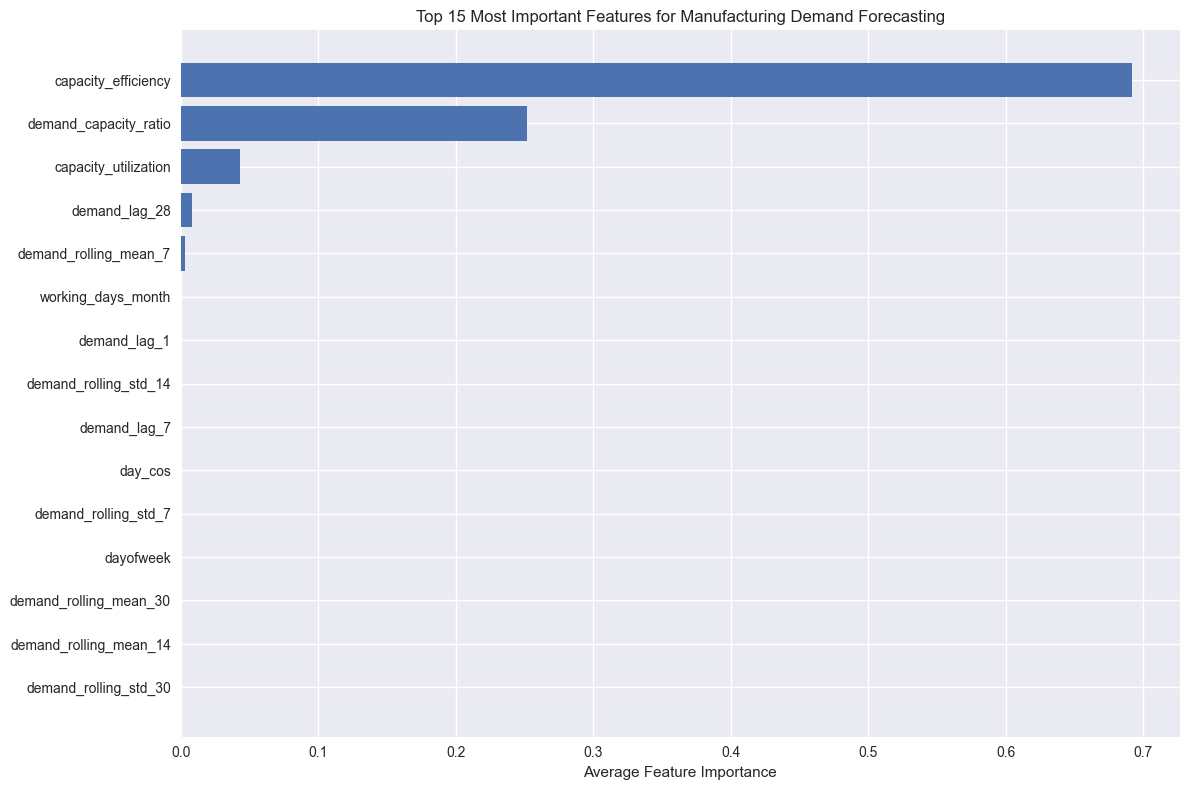

🔍 TOP 10 MOST IMPORTANT FEATURES:
 1. capacity_efficiency       0.6922
 2. demand_capacity_ratio     0.2521
 3. capacity_utilization      0.0428
 4. demand_lag_28             0.0080
 5. demand_rolling_mean_7     0.0032
 6. working_days_month        0.0005
 7. demand_lag_1              0.0003
 8. demand_rolling_std_14     0.0001
 9. demand_lag_7              0.0001
10. day_cos                   0.0001


In [24]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'lightgbm_importance': lgb_model.feature_importance(importance_type='gain'),
    'rf_importance': rf_model.feature_importances_
})

# Normalize importances
feature_importance['lightgbm_importance'] = feature_importance['lightgbm_importance'] / feature_importance['lightgbm_importance'].sum()
feature_importance['rf_importance'] = feature_importance['rf_importance'] / feature_importance['rf_importance'].sum()
feature_importance['avg_importance'] = (feature_importance['lightgbm_importance'] + feature_importance['rf_importance']) / 2

# Top 15 features
top_features = feature_importance.nlargest(15, 'avg_importance')

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['avg_importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Average Feature Importance')
plt.title('Top 15 Most Important Features for Manufacturing Demand Forecasting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("🔍 TOP 10 MOST IMPORTANT FEATURES:")
print("=" * 40)
for i, (_, row) in enumerate(top_features.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} {row['avg_importance']:.4f}")

In [29]:
# Advanced Forecasting Results Analysis
# Create results dataframe
results_df = test_data[['date', 'plant_id', 'product_line', 'product_category', 'demand_units']].copy()
results_df['predicted_demand'] = predictions[best_model]
results_df['prediction_error'] = results_df['demand_units'] - results_df['predicted_demand']
results_df['absolute_error'] = np.abs(results_df['prediction_error'])
results_df['percentage_error'] = (results_df['prediction_error'] / results_df['demand_units']) * 100

# Plant-wise performance
plant_performance = results_df.groupby('plant_id').agg({
    'demand_units': 'sum',
    'predicted_demand': 'sum',
    'absolute_error': 'mean',
    'percentage_error': lambda x: np.mean(np.abs(x))
}).round(2)

plant_performance['accuracy'] = 100 - plant_performance['percentage_error']
plant_performance.columns = ['Actual_Demand', 'Predicted_Demand', 'MAE', 'MAPE', 'Accuracy_%']

print("🏭 PLANT-WISE FORECASTING PERFORMANCE")
print("=" * 50)
print(plant_performance)

# Product category performance
category_performance = results_df.groupby('product_category').agg({
    'demand_units': 'sum',
    'predicted_demand': 'sum', 
    'absolute_error': 'mean',
    'percentage_error': lambda x: np.mean(np.abs(x))
}).round(2)

category_performance['accuracy'] = 100 - category_performance['percentage_error']
category_performance.columns = ['Actual_Demand', 'Predicted_Demand', 'MAE', 'MAPE', 'Accuracy_%']

print("\n📦 PRODUCT CATEGORY FORECASTING PERFORMANCE")
print("=" * 55)
print(category_performance)

🏭 PLANT-WISE FORECASTING PERFORMANCE
                   Actual_Demand  Predicted_Demand   MAE  MAPE  Accuracy_%
plant_id                                                                  
Plant_A_Mumbai            343644         343654.23  1.30  0.14       99.86
Plant_B_Chennai           284641         284647.85  1.13  0.16       99.84
Plant_C_Pune              260564         260619.91  1.09  0.19       99.81
Plant_D_Bangalore         314601         314551.04  1.24  0.15       99.85

📦 PRODUCT CATEGORY FORECASTING PERFORMANCE
                  Actual_Demand  Predicted_Demand   MAE  MAPE  Accuracy_%
product_category                                                         
Automotive               268457         268443.04  0.95  0.14       99.86
Chemicals                199470         199528.77  0.98  0.21       99.79
Electronics              333343         333368.08  1.19  0.13       99.87
Textiles                 402180         402133.14  1.65  0.15       99.85


In [30]:
# Raw Material Requirements Planning
def calculate_raw_material_requirements(forecast_df, raw_materials_df):
    """Calculate raw material requirements based on demand forecast"""
    
    # Material consumption ratios (units of raw material per unit of product)
    material_ratios = {
        'Electronics': {'Silicon_Wafers': 0.1, 'Copper_Wire': 2.5, 'Plastic_Components': 5.0, 'PCB_Boards': 0.5},
        'Automotive': {'Steel_Sheets': 15.0, 'Aluminum_Blocks': 8.0, 'Rubber_Parts': 3.0, 'Electronic_Modules': 0.2},
        'Textiles': {'Cotton_Fiber': 2.0, 'Polyester_Yarn': 1.5, 'Dyes_Chemicals': 0.1, 'Fabric_Softeners': 0.05},
        'Chemicals': {'Base_Chemicals': 10.0, 'Catalysts': 0.01, 'Solvents': 5.0, 'Additives': 0.5}
    }
    
    rm_requirements = []
    
    for _, row in forecast_df.iterrows():
        category = row['product_category']
        demand = row['predicted_demand']
        
        for material, ratio in material_ratios[category].items():
            required_qty = demand * ratio
            
            # Get material details
            material_info = raw_materials_df[raw_materials_df['material_id'] == material].iloc[0]
            
            rm_requirements.append({
                'date': row['date'],
                'plant_id': row['plant_id'],
                'product_line': row['product_line'],
                'product_category': category,
                'material_id': material,
                'required_quantity': required_qty,
                'unit_cost': material_info['unit_cost'],
                'total_cost': required_qty * material_info['unit_cost'],
                'lead_time_days': material_info['lead_time_days'],
                'min_order_qty': material_info['min_order_quantity']
            })
    
    return pd.DataFrame(rm_requirements)

# Calculate raw material requirements
print("🔧 Calculating raw material requirements...")
rm_forecast = calculate_raw_material_requirements(results_df, raw_materials)

# Aggregate by material and date
daily_rm_summary = rm_forecast.groupby(['date', 'material_id']).agg({
    'required_quantity': 'sum',
    'total_cost': 'sum',
    'lead_time_days': 'first',
    'min_order_qty': 'first'
}).reset_index()

# Weekly aggregation for planning
daily_rm_summary['week_period'] = daily_rm_summary['date'].dt.to_period('W')
# Convert Period to datetime for Streamlit compatibility
daily_rm_summary['week'] = daily_rm_summary['week_period'].dt.start_time

weekly_rm_summary = daily_rm_summary.groupby(['week', 'material_id']).agg({
    'required_quantity': 'sum',
    'total_cost': 'sum',
    'lead_time_days': 'first',
    'min_order_qty': 'first'
}).reset_index()

# Identify materials needing immediate ordering (considering lead times)
current_date = results_df['date'].max()
urgent_orders = weekly_rm_summary[
    weekly_rm_summary['week'] <= (current_date + pd.Timedelta(days=7))
]

print(f"\n📋 RAW MATERIAL REQUIREMENTS SUMMARY")
print(f"Total materials tracked: {weekly_rm_summary['material_id'].nunique()}")
print(f"Total weekly cost estimate: ${weekly_rm_summary['total_cost'].sum():,.2f}")

print("\n🚨 TOP 5 HIGHEST COST MATERIALS (Weekly):")
top_cost_materials = weekly_rm_summary.groupby('material_id')['total_cost'].sum().nlargest(5)
for material, cost in top_cost_materials.items():
    print(f"  • {material}: ${cost:,.2f}")

weekly_rm_summary.head(10)

🔧 Calculating raw material requirements...

📋 RAW MATERIAL REQUIREMENTS SUMMARY
Total materials tracked: 16
Total weekly cost estimate: $932,901,664.45

🚨 TOP 5 HIGHEST COST MATERIALS (Weekly):
  • Steel_Sheets: $322,131,651.77
  • Aluminum_Blocks: $257,705,321.42
  • Base_Chemicals: $199,528,771.42
  • PCB_Boards: $33,336,807.51
  • Solvents: $29,929,315.71


,week,material_id,required_quantity,total_cost,lead_time_days,min_order_qty
0,2025-06-30,Additives,22476.859816,1.685764e+06,8,200
1,2025-06-30,Aluminum_Blocks,488900.525720,5.866806e+07,12,100
2,2025-06-30,Base_Chemicals,449537.196319,4.495372e+07,10,500
3,2025-06-30,Catalysts,449.537196,2.247686e+05,15,20
4,2025-06-30,Copper_Wire,189153.092178,4.728827e+06,3,500
5,2025-06-30,Cotton_Fiber,179325.161490,8.966258e+05,2,5000
6,2025-06-30,Dyes_Chemicals,8966.258075,4.483129e+05,6,100
7,2025-06-30,Electronic_Modules,12222.513143,3.666754e+06,21,10
8,2025-06-30,Fabric_Softeners,4483.129037,5.379755e+04,4,1000
9,2025-06-30,PCB_Boards,37830.618436,7.566124e+06,10,50


In [31]:
# Save Advanced Models and Results
print("💾 Saving models and results...")

# Save best model
joblib.dump(models[best_model], f'../models/manufacturing_{best_model}_model.pkl')
joblib.dump(label_encoders, '../models/label_encoders.pkl')

# Save feature columns
with open('../models/feature_columns.txt', 'w') as f:
    for col in feature_cols:
        f.write(f"{col}\n")

# Save forecasting results
results_df.to_csv('../outputs/manufacturing_forecast_results.csv', index=False)
weekly_rm_summary.to_csv('../outputs/raw_material_requirements.csv', index=False)
plant_performance.to_csv('../outputs/plant_performance_metrics.csv')
category_performance.to_csv('../outputs/category_performance_metrics.csv')

# Save model metrics
metrics_df.to_csv('../outputs/model_comparison_metrics.csv')
top_features.to_csv('../outputs/feature_importance.csv', index=False)

print("✅ All files saved successfully!")
print("\n📁 Generated Files:")
print("  🤖 models/manufacturing_*_model.pkl")
print("  📊 outputs/manufacturing_forecast_results.csv")
print("  🔧 outputs/raw_material_requirements.csv")
print("  📈 outputs/*_performance_metrics.csv")
print("  🔍 outputs/feature_importance.csv")

print(f"\n🎯 FINAL MODEL PERFORMANCE SUMMARY")
print(f"Best Model: {best_model.upper()}")
print(f"RMSE: {metrics[best_model]['RMSE']:.2f}")
print(f"MAE: {metrics[best_model]['MAE']:.2f}")
print(f"MAPE: {metrics[best_model]['MAPE']:.2f}%")
print(f"Overall Accuracy: {100 - metrics[best_model]['MAPE']:.2f}%")

💾 Saving models and results...
✅ All files saved successfully!

📁 Generated Files:
  🤖 models/manufacturing_*_model.pkl
  📊 outputs/manufacturing_forecast_results.csv
  🔧 outputs/raw_material_requirements.csv
  📈 outputs/*_performance_metrics.csv
  🔍 outputs/feature_importance.csv

🎯 FINAL MODEL PERFORMANCE SUMMARY
Best Model: RANDOM_FOREST
RMSE: 1.76
MAE: 1.19
MAPE: 0.16%
Overall Accuracy: 99.84%
